In [1]:
# Packages
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import h5py
import netCDF4
from datetime import datetime
from glob import glob
import mercury as mr

In [2]:
# Functions and variables
def Ne_convert(e: float,P: float,T: float) -> float:
    """Convert electron concentration to density

    Args:
        e (float): Mixing ration
        P (float): Pressure
        T (float): Temperature

    Returns:
        float: Electron density
    """
    return e*P/(k*T)

def z(p):
    """Convert pressure to altitude

    Args:
        p (float): pressure (in hPa)

    Returns:
        float: altitude (in km)
    """
    return - 7 * np.log(p/1013.25)

def convert_utime(start_time: float, end_time: float):
    """Convert numpy.float65 to datetime.datetime 

    Args:
        start_time (float): Start time of the measured data
        end_time (float): End time of the measured data

    Returns:
        datetime,datetime: Date converted to datetime
    """
    start_time2, end_time2 = [], []
    if len(start_time) == len(end_time):
        for i in range(len(start_time)):
            start_time2.append(datetime.fromtimestamp(data['utime'][0][i]))
            end_time2.append(datetime.fromtimestamp(data['utime'][1][i]))
        return np.array(start_time2), np.array(end_time2)
    
def get_nrec(metadata,data):
    """Get nrec value from searching in metadata

    Args:
        metadata ([[String]]): Metadata array
        data ([[String]]): Data array
    Returns:
        int: number of height measurements 
    """
    i = 0
    for array in metadata:
        if array[0].strip() == b'nrec':
            return(data[i][0])
        i += 1

k = 1.38*10**(-23) # J/K
lim = 0.3
time_save = np.linspace(0,24,49)
H_list = np.linspace(80,132,14)

In [8]:
WACCM_path = '../../DataSorted/2004-11-11*/*.nc'
EISCAT_path = '../../DataSorted/2004-11-11*/*.hdf5'

WACCM_files = []
EISCAT_files = []

if len(glob(WACCM_path)) == 1:
    WACCM_files = [netCDF4.Dataset(glob(WACCM_path)[0])]
elif len(glob(WACCM_path)) > 1:
    for file in glob(WACCM_path):
        WACCM_files.append(netCDF4.Dataset(glob(file)[0]))
else:
    print('No files found')

if len(glob(EISCAT_path)) == 1:
    EISCAT_files = [h5py.File(glob(EISCAT_path)[0])]
elif len(glob(EISCAT_path)) > 1:
    for file in glob(EISCAT_path):
        EISCAT_files.append(h5py.File(glob(file)[0]))
else:
    print('No files found')

WACCM_file = WACCM_files[0]
EISCAT_file = EISCAT_files[0]

lat = WACCM_file['instr_lat'] 
lon = WACCM_file['instr_lon'] 
num = WACCM_file['instr_num'] 
date = WACCM_file['obs_date'] 
time = WACCM_file['obs_time']
lev = WACCM_file['lev']
e = WACCM_file['e']
T = WACCM_file['T'] 

mask_tromso = (lat[:] > 69.5) & (lat[:] < 69.7)
mask_svalbard = (lat[:] > 78.8) & (lat[:] < 79.0)

lev_mask = lev[:] < 0.01
P = lev[lev_mask]
H = z(P)
NeWACCM = []

for array in e[mask_svalbard]:
    NeWACCM.append(array[lev_mask])

NeWACCM = np.array(NeWACCM)
hours = time[mask_svalbard]/3600

mask_hours = [hours[i] > hours[i+1] for i in range(len(hours)-1)]
indices = [i+1 for i, value in enumerate(mask_hours) if value]

for indice in indices:
    hours[indice:] = hours[indice:] + 24

data = EISCAT_file['data']
metadata = EISCAT_file['metadata'] 

nrec = get_nrec(metadata['par0d'][:],data['par0d'][:])  
h = data['par2d'][0]
Ne = data['par2d'][2]
Ti = data['par2d'][3] 
Te = data['par2d'][4] 
ve = data['par2d'][6] 
Time = np.repeat(data['utime'][0], nrec)

start_date, end_date = convert_utime(data['utime'][0],data['utime'][1]) 
mask = h <= 150000 
Timebis = np.repeat(start_date, nrec) 
Time_hours_minutes = np.array([float(t.strftime('%H.%M')) for t in Timebis]) 
Date = start_date[0].strftime('%Y-%m-%d')
date_EISCAT = start_date[0].strftime('%Y%m%d')

h = h[mask]/1000
Ne = Ne[mask]
Ti = Ti[mask]
Te = Te[mask]
Te = Ti*Te
ve = ve[mask]
Time = Time[mask]
Timebis = Timebis[mask]
Time_hours_minutes = Time_hours_minutes[mask]

for i in range(len(Time_hours_minutes)-1):
    if Time_hours_minutes[i+1] < Time_hours_minutes[i]:
        Time_hours_minutes[i+1] = Time_hours_minutes[i+1] + 24


i = 0
for i in range(len(Time_hours_minutes)):
    fractional_part, integer_part = math.modf(float(Time_hours_minutes[i]))
    Time_hours_minutes[i] = integer_part + int(fractional_part/0.6*100)/100
    if int(date_EISCAT[-4:-2])!= int(str(date[0])[-4:-2]):
        if int(str(date[0])[-4:-2]) in [1,3,5,7,8,10,12]:
              Time_hours_minutes[i] += 24 * (int(date_EISCAT[-2:]) + int(str(date[0])[-2:]) - 31)
        elif int(str(date[0])[-4:-2]) == 2:
            Time_hours_minutes[i] += 24 * (int(date_EISCAT[-2:]) + int(str(date[0])[-2:]) - 38)
        else:
            Time_hours_minutes[i] += 24 * (int(date_EISCAT[-2:]) + int(str(date[0])[-2:]) - 30)
    elif int(date_EISCAT) != int(date[0]):
        Time_hours_minutes[i] += 24 * (int(date_EISCAT) - int(date[0]))
    
n = len(Time_hours_minutes)

newHours = np.array([])

Ne_diff_WACCM = np.array([])
Ne_diff_EISCAT = np.array([])
H_diff_WACCM = np.array([])
H_diff_EISCAT = np.array([])
time_diff_WACCM = np.array([])
time_diff_EISCAT = np.array([])

i = 0
while hours[i] < max(Time_hours_minutes) and i < len(hours) - 1:
    if hours[i] > min(Time_hours_minutes):
        Ne_diff_WACCM = np.concatenate((Ne_diff_WACCM, Ne_convert(NeWACCM[i],P*100,T[i][lev_mask])))
        H_diff_WACCM = np.concatenate((H_diff_WACCM, H))
        time_diff_WACCM = np.concatenate((time_diff_WACCM, [hours[i]]))
    i += 1
    
newHours = hours[:i]

i = 0
while newHours[i] < min(Time_hours_minutes):
    i += 1

newHours = newHours[i:]

i = 0
for i in range(len(newHours)):
    t_mask = (Time_hours_minutes > newHours[i]) & (Time_hours_minutes < newHours[i] + 0.5)
    if sum(t_mask) != 0:
        time1 = Time_hours_minutes[t_mask]
        Ne1 = Ne[t_mask]
        h1 = h[t_mask]
        for j in range(len(H)):
            h_mask = ((h1 - H[j])**2 < 10)
            if sum(h_mask != 0):
                Ne2 = np.mean(Ne1[h_mask])
                Ne_diff_EISCAT = np.concatenate((Ne_diff_EISCAT, np.array([Ne2])))
                H_diff_EISCAT = np.concatenate((H_diff_EISCAT, [H[j]]))
                time_diff_EISCAT = np.concatenate((time_diff_EISCAT, [newHours[i]]))
            else:
                Ne_diff_EISCAT = np.concatenate((Ne_diff_EISCAT, np.array([0])))
                H_diff_EISCAT = np.concatenate((H_diff_EISCAT, [H[j]]))
                time_diff_EISCAT = np.concatenate((time_diff_EISCAT, [newHours[i]]))
    else:
        Ne_diff_EISCAT = np.concatenate((Ne_diff_EISCAT, np.repeat([0], len(H))))
        H_diff_EISCAT = np.concatenate((H_diff_EISCAT, H))
        time_diff_EISCAT = np.concatenate((time_diff_EISCAT, np.repeat(hours[i], len(H))))
    
mask = Ne_diff_EISCAT != 0
time_diff = time_diff_EISCAT
H_diff = H_diff_EISCAT

corr_factor_model = np.zeros(len(np.unique(H_diff))*len(time_diff_WACCM))
corr_factor_model[mask] = (Ne_diff_EISCAT[mask] - Ne_diff_WACCM[mask])/Ne_diff_WACCM[mask]

corr_factor_measure = np.zeros(len(np.unique(H_diff))*len(time_diff_WACCM))
corr_factor_measure[mask] = (Ne_diff_EISCAT[mask] - Ne_diff_WACCM[mask])/Ne_diff_EISCAT[mask]


diff_density = np.abs(Ne_diff_WACCM - Ne_diff_EISCAT)
diff_density[~mask] = 0

if min(time_diff) > 24:
    time_diff = time_diff - 24 * (min(time_diff) // 24)

mask24 = time_diff <= 24

time_diff = time_diff[mask24]
H_diff = H_diff[mask24]
corr_factor_model = corr_factor_model[mask24]
corr_factor_measure = corr_factor_measure[mask24]
Ne_diff_WACCM = Ne_diff_WACCM[mask24]
Ne_diff_EISCAT = Ne_diff_EISCAT[mask24]
Ne_diff = np.abs(Ne_diff_WACCM - Ne_diff_EISCAT)


good_mask_model = np.abs(corr_factor_model) < lim
good_mask_measure = np.abs(corr_factor_measure) < lim
global_corr_model = sum(good_mask_model)/len(Ne_diff_WACCM)*100
global_corr_measure = sum(good_mask_measure)/len(Ne_diff_WACCM)*100

Ne_list = []
Ne_WACCM = []
Ne_EISCAT = []

for h in H_list:
    h_mask = np.abs(H_diff - h) <= 2
    Ne_diff1 = Ne_diff[h_mask]
    Ne_WACCM1 = Ne_diff_WACCM[h_mask]
    Ne_EISCAT1 = Ne_diff_EISCAT[h_mask]
    for time_incr in time_save:
        t_mask = np.abs(time_diff[h_mask] - time_incr) < 0.25
        if sum(t_mask) == 0:
            Ne_list.append(0)
            Ne_WACCM.append(0)
            Ne_EISCAT.append(0)
        else:
            Ne_diff2 = int(np.mean(Ne_diff1[t_mask]))
            Ne_WACCM2 = int(np.mean(Ne_WACCM1[t_mask]))
            Ne_EISCAT2 = int(np.mean(Ne_EISCAT1[t_mask]))
            Ne_list.append(Ne_diff2)
            Ne_WACCM.append(Ne_WACCM2)
            Ne_EISCAT.append(Ne_EISCAT2)

Ne_array = np.array(Ne_list)
Ne_WACCM_array = np.array(Ne_WACCM)
Ne_EISCAT_array = np.array(Ne_EISCAT)

corr_model_list = []
corr_measure_list = []

for h in H_list:
    h_mask = np.abs(H_diff - h) <= 2
    corr1_model = corr_factor_model[h_mask]
    corr1_measure = corr_factor_measure[h_mask]
    for time_incr in time_save:
        t_mask = np.abs(time_diff[h_mask] - time_incr) < 0.25
        if sum(t_mask) == 0:
            corr_model_list.append(0)
            corr_measure_list.append(0)
        else:
            corr2_model = np.mean(corr1_model[t_mask])
            corr2_measure = np.mean(corr1_measure[t_mask])
            corr_model_list.append(corr2_model)
            corr_measure_list.append(corr2_measure)

corr_model_array = np.array(corr_model_list)
corr_measure_array = np.array(corr_measure_list)
mask_corr = corr_model_array == 0
Ne_array[mask_corr] = 0

mask = np.array(Ne_array) != 0
frequency = np.zeros(len(time_save)*len(np.unique(H_list)) + 1)
frequency[1:][mask] = 1

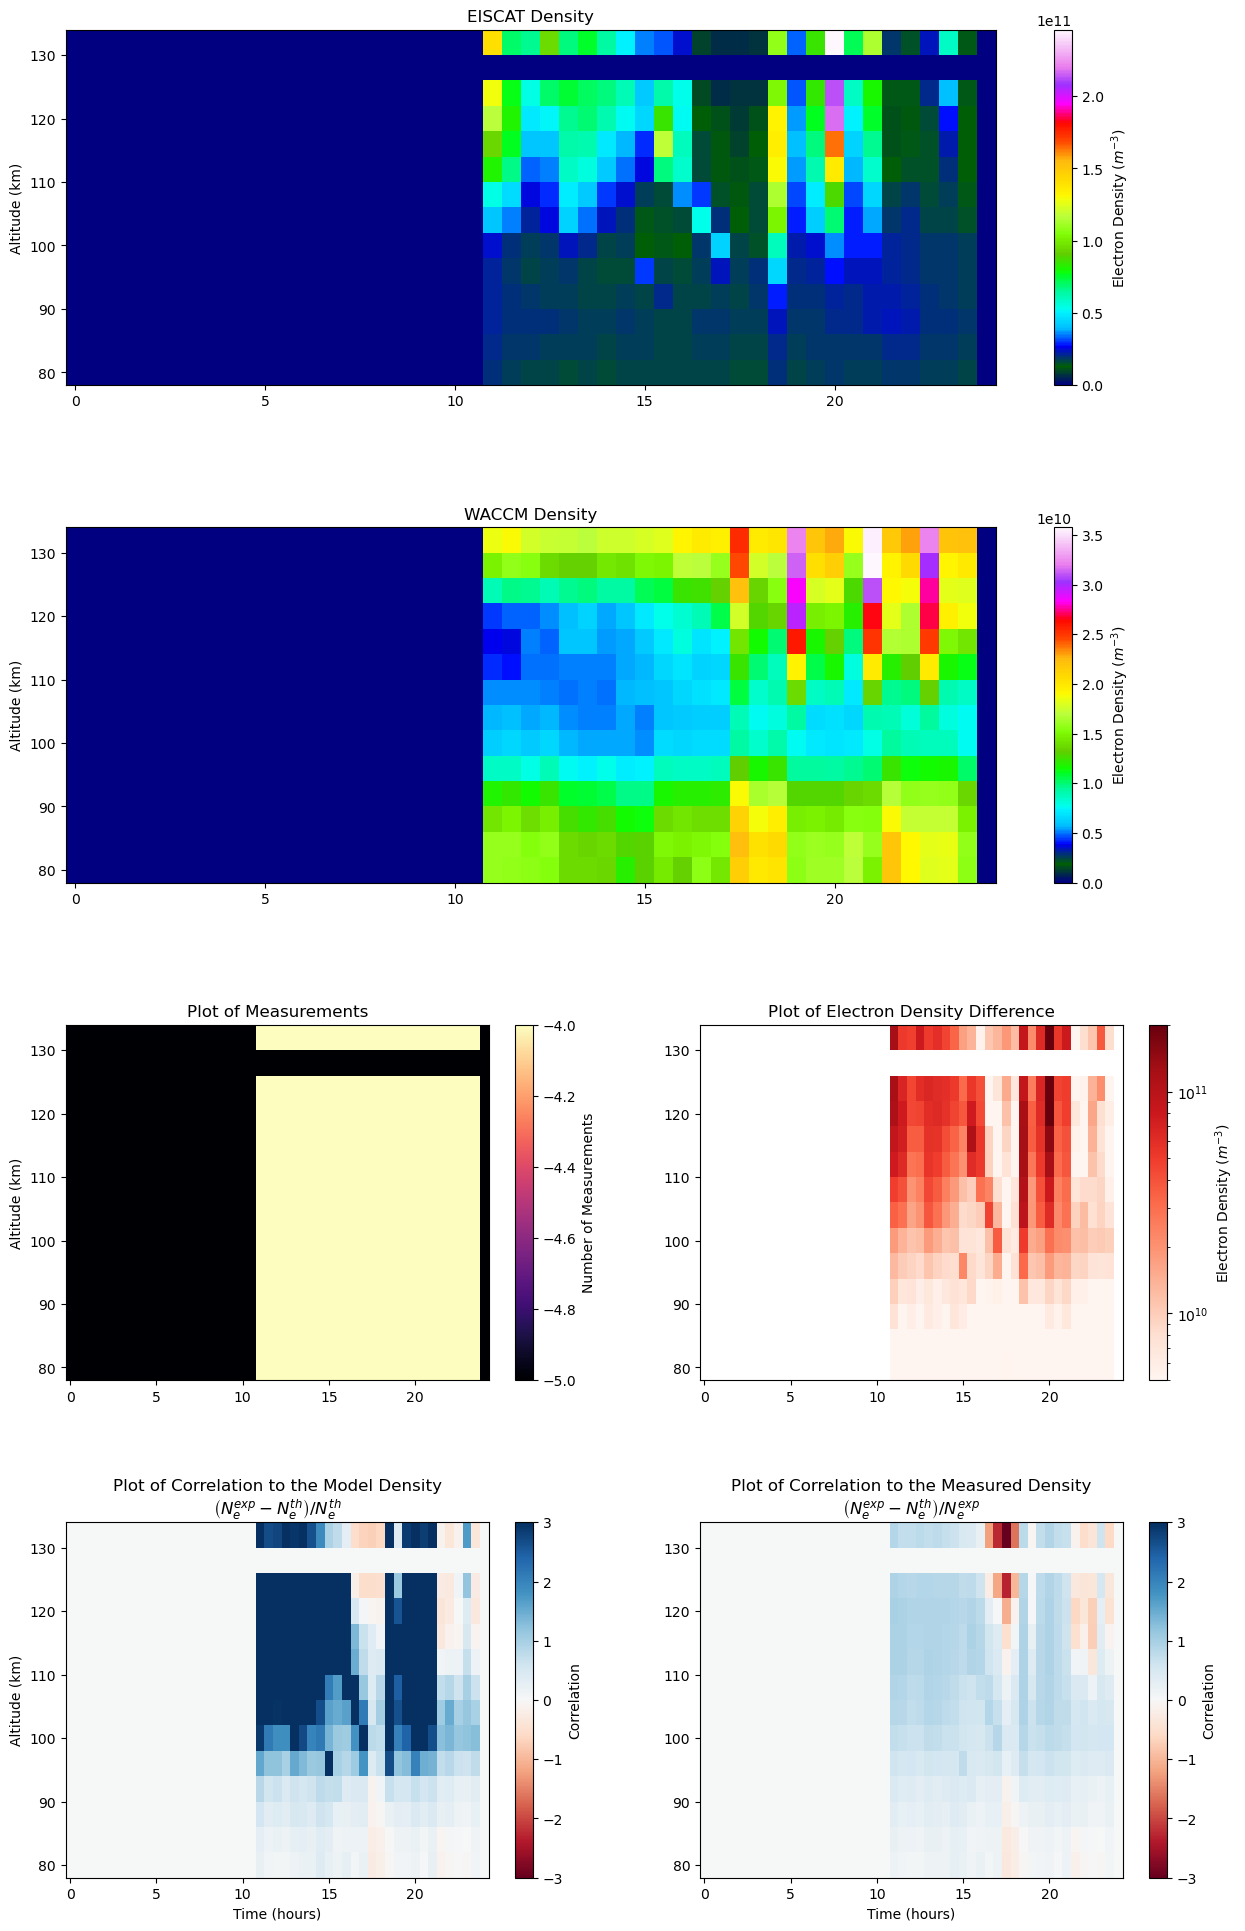

In [85]:
mask = frequency[1:] != 1
frequency[1:][mask] -= 1
frequency_grid = frequency[1:].reshape(len(H_list), len(time_save))

density_grid = Ne_array.reshape(len(H_list), len(time_save))
WACCM_grid = Ne_WACCM_array.reshape(len(H_list), len(time_save))
EISCAT_grid = Ne_EISCAT_array.reshape(len(H_list), len(time_save))

model_correlation = corr_model_array.reshape(len(H_list), len(time_save))
measure_correlation = corr_measure_array.reshape(len(H_list), len(time_save))

frequency[1:][~mask] -= 1

fig = plt.figure(figsize=(15, 24))
gs = fig.add_gridspec(4, 2, hspace=0.4, wspace=0.2)

# EISCAT density on the whole first row
ax0 = fig.add_subplot(gs[0, :])
contour0 = ax0.pcolormesh(time_save, H_list, EISCAT_grid, cmap='gist_ncar')
cbar = fig.colorbar(contour0, ax=ax0)
cbar.set_label(r'Electron Density ($m^{-3}$)')
ax0.set_ylabel('Altitude (km)')
ax0.set_title('EISCAT Density')

# WACCM density on the whole second row
ax1 = fig.add_subplot(gs[1, :])
contour1 = ax1.pcolormesh(time_save, H_list, WACCM_grid, cmap='gist_ncar')
cbar = fig.colorbar(contour1, ax=ax1)
cbar.set_label(r'Electron Density ($m^{-3}$)')
ax1.set_ylabel('Altitude (km)')
ax1.set_title('WACCM Density')

# Plot Measurements (third row, left column)
ax2 = fig.add_subplot(gs[2, 0])
contour2 = ax2.pcolormesh(time_save, H_list, frequency_grid, cmap='magma')
cbar = fig.colorbar(contour2, ax=ax2)
cbar.set_label('Number of Measurements')
ax2.set_ylabel('Altitude (km)')
ax2.set_title('Plot of Measurements')

# Plot Electron Density Difference (third row, right column)
ax3 = fig.add_subplot(gs[2, 1])
contour3 = ax3.pcolormesh(time_save, H_list, density_grid, cmap='Reds', norm=LogNorm(vmin=5e9, vmax=2e11))
cbar = fig.colorbar(contour3, ax=ax3)
cbar.set_label(r'Electron Density ($m^{-3}$)')
ax3.set_title('Plot of Electron Density Difference')

# Plot Correlation to Model Density (fourth row, left column)
ax4 = fig.add_subplot(gs[3, 0])
norm = Normalize(vmin=-3, vmax=3)
contour4 = ax4.pcolormesh(time_save, H_list, model_correlation, cmap='RdBu', norm=norm)
cbar = fig.colorbar(contour4, ax=ax4)
cbar.set_label('Correlation')
ax4.set_xlabel('Time (hours)')
ax4.set_ylabel('Altitude (km)')
ax4.set_title('Plot of Correlation to the Model Density' + '\n' + r'$\left(N_e^{exp} - N_e^{th}\right)/N_e^{th}$')

# Plot Correlation to Measured Density (fourth row, right column)
ax5 = fig.add_subplot(gs[3, 1])
contour5 = ax5.pcolormesh(time_save, H_list, measure_correlation, cmap='RdBu', norm=norm)
cbar = fig.colorbar(contour5, ax=ax5)
cbar.set_label('Correlation')
ax5.set_xlabel('Time (hours)')
ax5.set_title('Plot of Correlation to the Measured Density' + '\n' + r'$\left(N_e^{exp} - N_e^{th}\right)/N_e^{exp}$')

plt.show()
